In [1]:
import os

from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


plt.rcParams["figure.figsize"] = (12, 8)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2022-02-08 19:18:56.153195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marek/anaconda3/envs/cv/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-08 19:18:56.153210: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (14, 8)


<center> <h2> Problem and dataset description

In [3]:
# TODO: Write a short description of the problem

Link to the dataset can be found [here](https://www.kaggle.com/datamunge/sign-language-mnist).

<center> <h2> Data overview

In [4]:
ROOT_PATH = Path().resolve().parent
DATA_PATH = ROOT_PATH.joinpath("data")
MNIST_TRAIN = DATA_PATH.joinpath("sign_mnist_train.csv")
MNIST_TEST = DATA_PATH.joinpath("sign_mnist_test.csv")


In [5]:
train_df = pd.read_csv(MNIST_TRAIN)
test_df = pd.read_csv(MNIST_TEST)


In [6]:
test = pd.read_csv(MNIST_TEST)
y = test["label"]


In [7]:
train_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


<center> <h2> Preprocessing

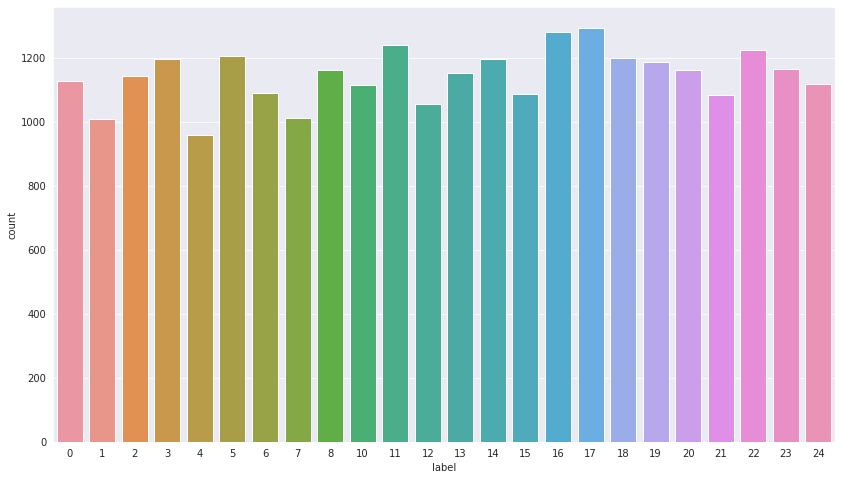

In [8]:
_ = sns.countplot(x=train_df["label"])


In [9]:
y_train, X_train_df = train_df["label"], train_df.drop("label", axis=1)
y_test, X_test_df = test_df["label"], test_df.drop("label", axis=1)



In [10]:

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)


In [11]:
x_train = X_train_df.values
x_test = X_test_df.values


In [12]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255


In [13]:
# Reshaping the to an image with single chanel
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


<center> <h3> Preview of first the images

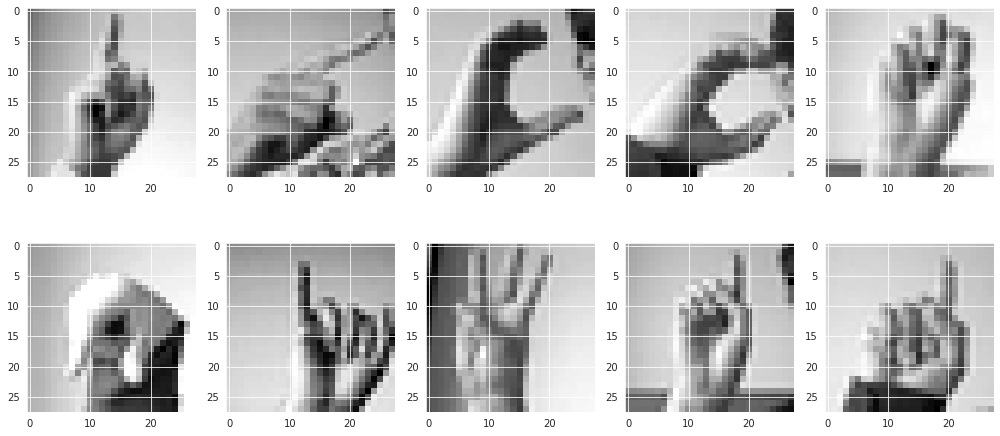

In [14]:
rows, cols = (2, 5)

f, ax = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(x_train[i * cols + j].reshape(28, 28), cmap="gray")
    plt.tight_layout()

plt.show()



<center> <h2> Data Augmentation


In [15]:
# TODO: Verify (Maybe add background to images???); Does it work well??
# TODO: We do not have enough data??? < 1000 examples?

In [16]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
)  # randomly flip images


datagen.fit(x_train)


For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

<center> <h2> The Model

In [17]:
# TODO: Verify the model / experiment a bit - to change

In [18]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001
)



In [19]:
model = Sequential()
model.add(
    Conv2D(
        75,
        (3, 3),
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(28, 28, 1),
    )
)
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(24, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

2022-02-08 19:19:02.252392: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-02-08 19:19:02.252418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fedora-desktop
2022-02-08 19:19:02.252423: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: fedora-desktop
2022-02-08 19:19:02.252489: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-02-08 19:19:02.252505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.46.0
2022-02-08 19:19:02.252510: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 495.46.0 does not match DSO version 510.47.3 -- cannot find working devices in this configuration
2022-02-08 19:19:02.252685: I tensorflow/core/platform/cpu_feature_guard.cc:151] Thi

In [20]:
# Lol - kernel version mismatched with libcuda, look at that ^^^, probably need a reboot?

In [ ]:
# TODO: Add checkpoints?? (As in generator.ipynb)

In [ ]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[learning_rate_reduction],
)



In [ ]:
print("Accuracy of the model: ", model.evaluate(x_test, y_test)[1] * 100, "%")


In [21]:
# TODO: Save the model and history (?)

<center> <h2> Model Overview

In [ ]:
# TODO: Verify plots, mabe add some more?
# TODO: Change hardocded values!

In [ ]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

ax[0].plot(epochs, train_acc, "go-", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Testing Accuracy")
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "g-o", label="Training Loss")
ax[1].plot(epochs, val_loss, "r-o", label="Testing Loss")
ax[1].set_title("Testing Accuracy & Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)
for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1
predictions[:5]


In [ ]:
x_test.shape


In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]

print(predictions.shape, y.shape)
print(classification_report(y, predictions, target_names=classes))


In [ ]:
cm = confusion_matrix(y, predictions)


In [ ]:
cm = pd.DataFrame(
    cm, index=[i for i in range(25) if i != 9], columns=[i for i in range(25) if i != 9]
)


In [ ]:
plt.figure()
_ = sns.heatmap(cm, cmap="Blues", linecolor="black", linewidth=1, annot=True, fmt="")

plt.show()

In [ ]:
correct = predictions[predictions == y]
correct.shape


**Some of the Correctly Predicted Classes**

In [ ]:
i = 0
plt.figure()
for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.imshow(x_test[c].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1
